In [1]:
# Imports
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from helpers import MultipleTimeSeriesCV, plot_ic_distribution, plot_rolling_ic

### Engineered Features

In [2]:
# Loading the data
data = pd.read_csv('./data/featureset.csv')
data.date = pd.to_datetime(data.date)
data.set_index(["ticker", "date"], inplace=True)
data.dropna(inplace=True)

In [3]:
# Specifying features and targets
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)

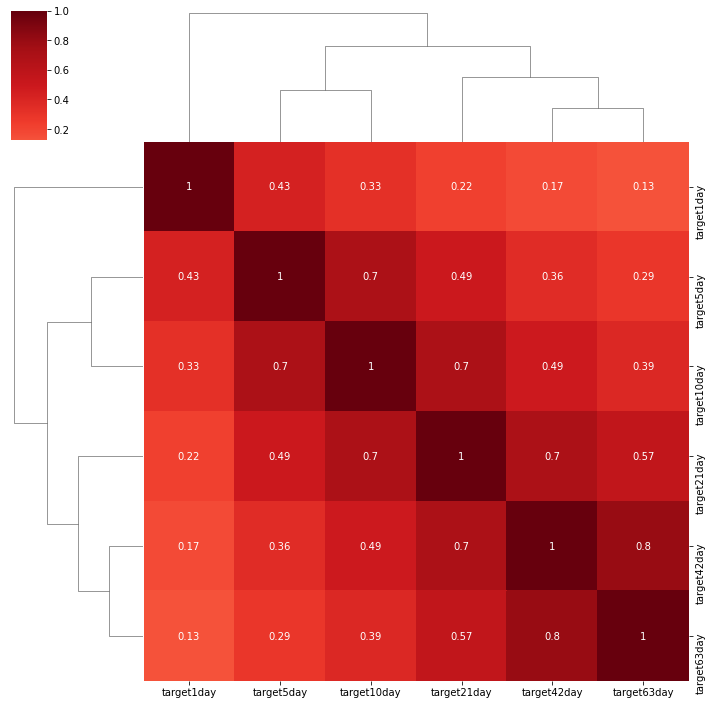

In [78]:
# Correlation for y
sns.clustermap(y.corr(), cmap="Reds", center=0, annot=True);

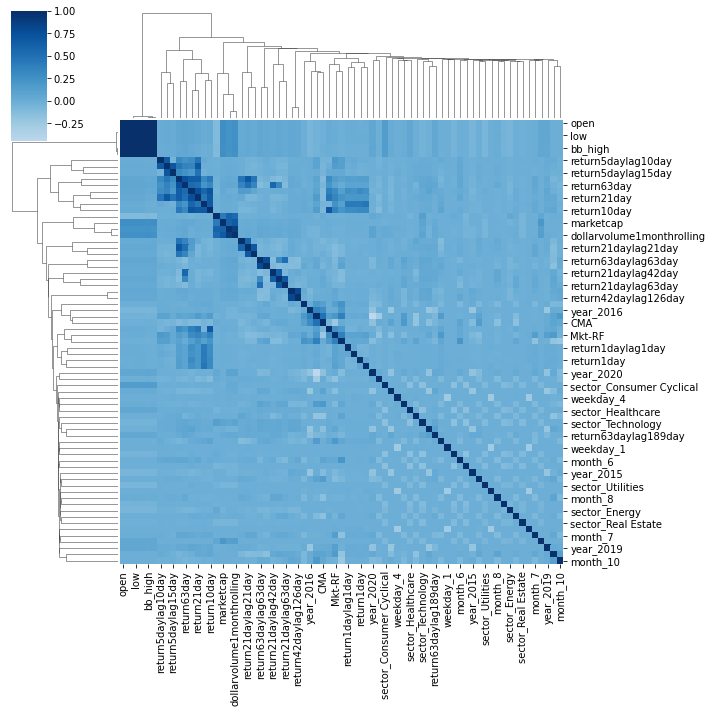

In [79]:
# Correlation for X
sns.clustermap(X.corr(), cmap="Blues", center=0);

In [81]:
# Correlation matrix for features
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)
corr_mat[abs(corr_mat["corr"])>0.25]

,var1,var2,corr
215,close,low,0.999905
145,low,close,0.999905
1,open,high,0.999902
71,high,open,0.999902
214,close,high,0.999901
...,...,...,...
2161,weekday_1,weekday_2,-0.257476
659,HML,month_3,-0.268493
1429,month_3,HML,-0.268493
1287,year_2020,HML,-0.441243


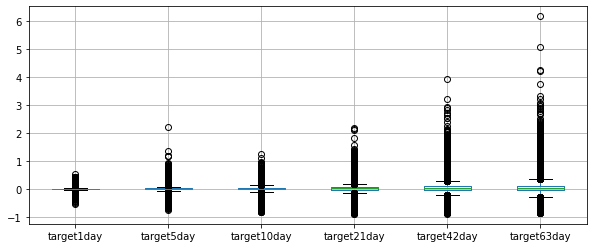

In [400]:
#  Boxplot for targets
plt.figure(figsize=(10,4))
y.boxplot();

### Data Preparation

In [32]:
# Standardising ticker-wise constant features
temp = X.filter(like="sector")
temp["marketcap"] = (X.marketcap-X.marketcap.min())/(X.marketcap.max()-X.marketcap.min())

C:\Users\Ishan\AppData\Local\Temp/ipykernel_4756/1756768749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["marketcap"] = (X.marketcap-X.marketcap.min())/(X.marketcap.max()-X.marketcap.min())


In [33]:
# Standardising features ticker-wise
X.drop(columns=temp.columns, inplace=True)
X = X.groupby(level='ticker').apply(lambda x: (x-x.mean())/(x.std()))
X = X.join(temp)
X = X.dropna()
X

open      high       low     close    volume  \
ticker date                                                           
A      2015-01-02 -1.168178 -1.181047 -1.192890 -1.202542 -0.591378   
       2015-01-05 -1.214749 -1.226606 -1.229570 -1.243687 -0.145821   
       2015-01-06 -1.242366 -1.250189 -1.266798 -1.277252 -0.112096   
       2015-01-07 -1.258071 -1.261446 -1.252017 -1.249101  0.999710   
       2015-01-08 -1.219081 -1.198735 -1.203292 -1.184677 -0.081065   
...                     ...       ...       ...       ...       ...   
ZTS    2020-09-25  2.324790  2.390333  2.367581  2.421048 -1.095814   
       2020-09-28  2.463421  2.473717  2.483430  2.435102 -0.347086   
       2020-09-29  2.447594  2.446791  2.491726  2.469065 -1.197836   
       2020-09-30  2.485696  2.544651  2.530540  2.553680 -0.611074   
       2020-10-01  2.582708  2.544362  2.540909  2.514446 -1.187198   

                   dollarvolume  dollarvolume1monthrolling    Mkt-RF  \
ticker date                                                            
A      2015-01-02     -0.959471                  -1.095025 -0.919717   
       2015-01-05     -0.708542                  -1.108920 -0.919717   
       2015-01-06     -0.705226                  -1.083456 -0.919717   
       2015-01-07     -0.028813                  -0.990689 -0.919717   
       2015-01-08     -0.639784                  -0.962461 -0.919717   
...                         ...                        ...       ...   
ZTS    2020-09-25     -0.059304                   0.628979 -1.038544   
       2020-09-28      1.851592                   0.789980 -1.038544   
       2020-09-29     -0.299616                   0.808392 -1.038544   
       2020-09-30      1.263067                   0.886214 -1.038544   
       2020-10-01     -0.254656                   0.859137 -0.688920   

                        SMB       HML  ...  sector_Consumer Cyclical  \
ticker date                            ...                             
A      2015-01-02 -0.207736 -0.862057  ...                         0   
       2015-01-05 -0.207736 -0.862057  ...                         0   
       2015-01-06 -0.207736 -0.862057  ...                         0   
       2015-01-07 -0.207736 -0.862057  ...                         0   
       2015-01-08 -0.207736 -0.862057  ...                         0   
...                     ...       ...  ...                       ...   
ZTS    2020-09-25  0.145130 -0.524268  ...                         0   
       2020-09-28  0.145130 -0.524268  ...                         0   
       2020-09-29  0.145130 -0.524268  ...                         0   
       2020-09-30  0.145130 -0.524268  ...                         0   
       2020-10-01  1.924638  1.579674  ...                         0   

                   sector_Consumer Defensive  sector_Energy  \
ticker date                                                   
A      2015-01-02                          0              0   
       2015-01-05                          0              0   
       2015-01-06                          0              0   
       2015-01-07                          0              0   
       2015-01-08                          0              0   
...                                      ...            ...   
ZTS    2020-09-25                          0              0   
       2020-09-28                          0              0   
       2020-09-29                          0              0   
       2020-09-30                          0              0   
       2020-10-01                          0              0   

                   sector_Financial Services  sector_Healthcare  \
ticker date                                                       
A      2015-01-02                          0                  1   
       2015-01-05                          0                  1   
       2015-01-06                          0                  1   
       2015-01-07                          0                  1   
   

In [34]:
# Dropping values dropped in X
y = y.loc[X.index]
y

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02   -0.018738    0.000740    -0.056953    -0.023176   
       2015-01-05   -0.015578    0.007789    -0.046985    -0.017337   
       2015-01-06    0.013272    0.009443    -0.026034     0.008933   
       2015-01-07    0.029975   -0.016121    -0.001259    -0.009068   
       2015-01-08   -0.007337   -0.070433    -0.050868    -0.045243   
...                       ...         ...          ...          ...   
ZTS    2020-09-25    0.002984    0.016849     0.028538    -0.000989   
       2020-09-28    0.007191    0.013203     0.044818     0.008389   
       2020-09-29    0.017787   -0.005908     0.017479    -0.022103   
       2020-09-30   -0.008103   -0.033017    -0.010340    -0.024057   
       2020-10-01   -0.002926   -0.005243    -0.006340    -0.032199   

                   target42day  target63day  
ticker date                                  
A      2015-01-02     0.040927     0.036323  
       2015-01-05     0.043467     0.068958  
       2015-01-06     0.065339     0.081268  
       2015-01-07     0.023426     0.072913  
       2015-01-08    -0.000978     0.067676  
...                        ...          ...  
ZTS    2020-09-25     0.002621     0.000505  
       2020-09-28    -0.005762     0.007893  
       2020-09-29    -0.004972     0.005196  
       2020-09-30    -0.028961    -0.005408  
       2020-10-01    -0.015046     0.010225  

[695339 rows x 6 columns]

### Linear Regression

In [86]:
# OLS Summary for 1 day holding predictions
target = 'target1day'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

C:\Users\Ishan\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             target1day   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     411.9
Date:                Thu, 02 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:55:44   Log-Likelihood:             1.7255e+06
No. Observations:              695339   AIC:                        -3.451e+06
Df Residuals:                  695267   BIC:                        -3.450e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [87]:
# OLS Summary for 3 month holding predictions
target = 'target63day'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

C:\Users\Ishan\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:            target63day   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     2279.
Date:                Thu, 02 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:55:50   Log-Likelihood:             4.0619e+05
No. Observations:              695339   AIC:                        -8.122e+05
Df Residuals:                  695267   BIC:                        -8.114e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Ridge Regression

In [276]:
# Specifying list of alphas for regularization
ridge_alphas = np.logspace(-5, 5, 11)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))
ridge_coeffs_list = []
ridge_scores_list = []
ridge_predictions_list = []

In [277]:
# Training and cross-validating model using 4 years of data
for lookahead in [1,5,10,21,42,63]:
    print(lookahead)
    train_period_length = 63
    test_period_length = 21
    n_splits = int(4 * 21 * 12 / test_period_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
    
    target = f'target{lookahead}day'
    ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

    for alpha in ridge_alphas:
        print(alpha, end=' ', flush=True)
        model = Ridge(alpha=alpha,
                      fit_intercept=False)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)])

        coeffs = []
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        
            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='date')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                                .to_frame('rmse')], axis=1)

            ridge_scores.append(scores.assign(alpha=alpha))
            ridge_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

    print('\n')
    
    ridge_coeffs_list.append(pd.DataFrame(ridge_coeffs, index=X.columns).T)
    ridge_scores_list.append(pd.concat(ridge_scores))
    ridge_predictions_list.append(pd.concat(ridge_predictions))

1
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 

5
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 

10
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 

21
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 

42
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 

63
1e-05 5e-05 0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 100000.0 500000.0 



In [288]:
# Getting Information Coefficient and p-value
ridge_r_list = []
ridge_p_list = []
targets = [1,5,10,21,42,63]
for x in range(len(ridge_predictions_list)):
    ridge_r, ridge_p = spearmanr(ridge_predictions_list[x].actuals, ridge_predictions_list[x].predicted)
    print(f'{targets[x]}: Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')
    ridge_r_list.append(ridge_r)
    ridge_p_list.append(ridge_p)

1: Information Coefficient (overall): 1.285% (p-value: 0.0000%)
5: Information Coefficient (overall): 2.426% (p-value: 0.0000%)
10: Information Coefficient (overall): 4.582% (p-value: 0.0000%)
21: Information Coefficient (overall): -6.783% (p-value: 0.0000%)
42: Information Coefficient (overall): -0.385% (p-value: 0.0000%)
63: Information Coefficient (overall): 2.934% (p-value: 0.0000%)


In [298]:
# Further analysis on 10 day holding period
mic = 2
ridge_scores_list[mic].groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.00001,1008.0,6.622900,13.629131,-34.707021,-1.262243,7.539822,15.221786,51.724644
0.00005,1008.0,6.645210,13.655867,-34.701080,-1.296408,7.577844,15.256716,51.772587
0.00010,1008.0,6.646585,13.656417,-34.706504,-1.319964,7.573568,15.254745,51.778754
0.00050,1008.0,6.663322,13.785303,-35.841819,-1.374994,7.631345,15.409104,51.795210
0.00100,1008.0,6.622213,13.827974,-35.840902,-1.457908,7.563788,15.289022,51.820971
0.00500,1008.0,6.569130,13.809986,-35.847674,-1.483694,7.517722,15.527547,51.887039
0.01000,1008.0,6.581485,13.811230,-35.853044,-1.485144,7.503526,15.576654,51.940697
0.05000,1008.0,6.568264,13.861853,-35.856295,-1.372729,7.522391,15.603439,52.031524
0.10000,1008.0,6.573605,13.872751,-35.869774,-1.324450,7.541046,15.577368,52.033637


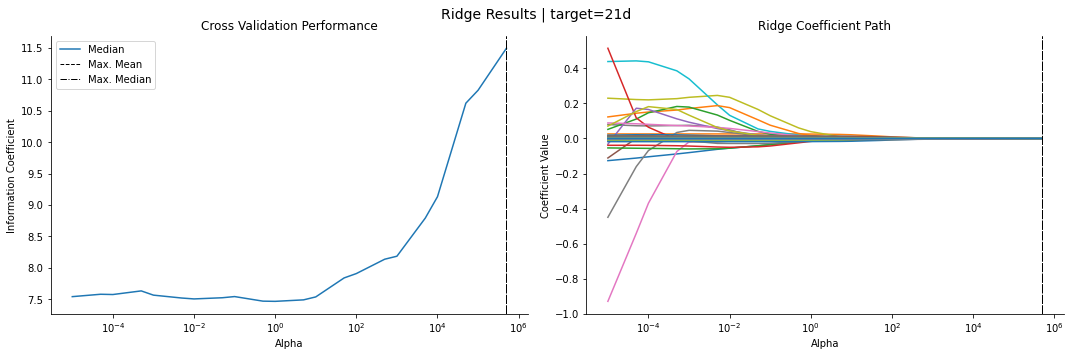

In [299]:
# Plotting IC and linear coefficients vs alpha
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores_list[mic].groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs_list[mic].plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results | target=10d', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

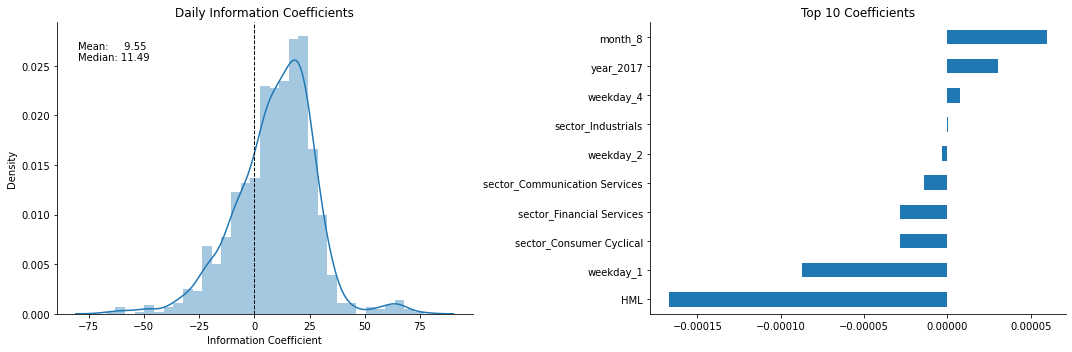

In [300]:
# Getting top ten weights for best IC alpha
best_alpha = ridge_scores_list[mic].groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores_list[mic][ridge_scores_list[mic].alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs_list[mic].loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs_list[3].loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

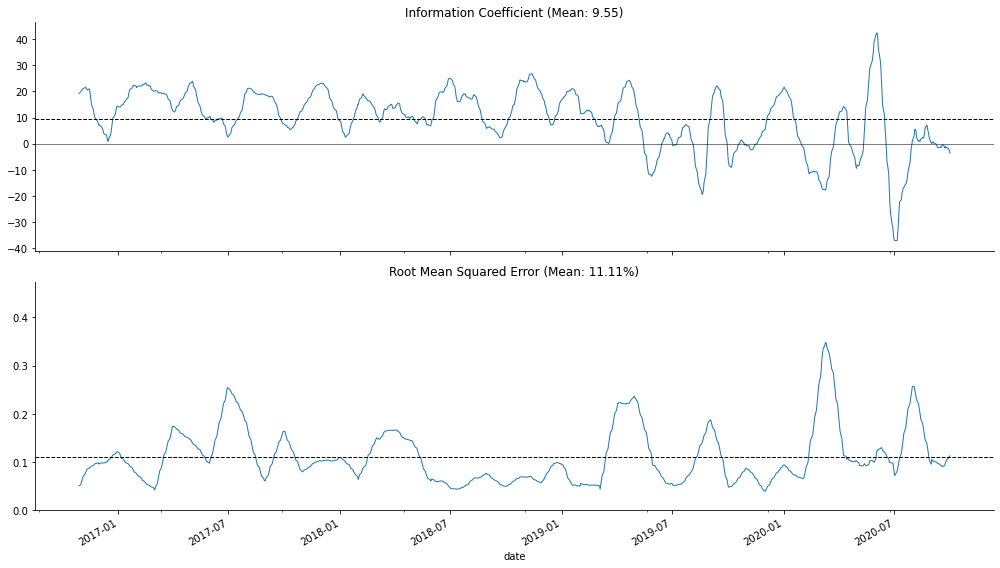

In [301]:
# Plotting rolling IC for best IC alpha
plot_rolling_ic(ridge_scores_list[mic][ridge_scores_list[mic].alpha==best_alpha])

In [4]:
# Splitting into training set
X_train = X.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]
y_train = y.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]

In [53]:
# Fitting model to training set and predicting returns
model = Ridge(alpha=50000.0, fit_intercept=False)
pipe = Pipeline([('scaler', StandardScaler()),('model', model)])
pipe.fit(X=X_train, y=y_train)
y_pred = pipe.predict(X)

In [55]:
# Converting predictions to DataFrame
y_pred = pd.DataFrame(y_pred, index=y.index, columns=y.columns)
y_pred

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02   -0.002072   -0.003902    -0.002480     0.007879   
       2015-01-05   -0.000865   -0.000959     0.002833     0.014328   
       2015-01-06   -0.000441    0.000085     0.005259     0.016248   
       2015-01-07   -0.001368   -0.000359     0.006563     0.013884   
       2015-01-08   -0.002537   -0.005129    -0.001953     0.004056   
...                       ...         ...          ...          ...   
ZTS    2020-09-25   -0.050407   -0.238755    -0.471752    -1.004242   
       2020-09-28   -0.050763   -0.241372    -0.475707    -1.008366   
       2020-09-29   -0.050232   -0.242243    -0.476691    -1.010409   
       2020-09-30   -0.051076   -0.243429    -0.478062    -1.011230   
       2020-10-01   -0.049706   -0.236140    -0.464222    -0.977510   

                   target42day  target63day  
ticker date                                  
A      2015-01-02     0.014320     0.024618  
       2015-01-05     0.025880     0.038571  
       2015-01-06     0.027556     0.044264  
       2015-01-07     0.021741     0.043780  
       2015-01-08     0.011160     0.030010  
...                        ...          ...  
ZTS    2020-09-25    -2.105918    -2.961053  
       2020-09-28    -2.110926    -2.965136  
       2020-09-29    -2.107848    -2.963528  
       2020-09-30    -2.111953    -2.964114  
       2020-10-01    -2.086054    -2.955767  

[695339 rows x 6 columns]

In [56]:
# Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.date = pd.to_datetime(ohlcv.date)
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [72]:
# Joining OHLCV data with predictions
ridge_preds = ohlcv.join(y_pred).dropna()
ridge_preds.to_csv('./predictions/ridge_preds.csv')

### Logistic Regression

In [407]:
# Specifying list of Cs for inverse regularization
log_cs = np.logspace(-5, 5, 11)
log_coeffs_list = []
log_scores_list = []
log_predictions_list = []

In [412]:
# Training and cross-validating model using 4 years of data
for lookahead in [1,5,10,21,42,63]:
    target = f'target{lookahead}day'
    y.loc[:, 'label'] = (y[target] > 0).astype(int)
    print(lookahead)
    train_period_length = 63
    test_period_length = 21
    n_splits = int(4 * 21 * 12 / test_period_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
    
    log_coeffs, log_scores, log_predictions = {}, [], []

    for C in log_cs:
        print(C, end=' ', flush=True)
        model = LogisticRegression(C=C,
                               fit_intercept=True,
                               n_jobs=-1)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)])

        ics = aucs = 0
        coeffs = []
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
            pipe.fit(X=X_train, y=y_train)
            X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
            actuals = y[target].iloc[test_idx]
            if len(y_test) < 10 or len(np.unique(y_test)) < 2:
                continue
            y_score = pipe.predict_proba(X_test)[:, 1]
       
            auc = roc_auc_score(y_score=y_score, y_true=y_test)
            actuals = y[target].iloc[test_idx]
            ic, pval = spearmanr(y_score, actuals)

            log_predictions.append(y_test.to_frame('labels').assign(
                predicted=y_score, C=C, actuals=actuals))
            date = y_test.index.get_level_values('date').min()
            log_scores.append([C, date, auc, ic * 100, pval])
            coeffs.append(pipe.named_steps['model'].coef_)
            ics += ic
            aucs += auc
    
        log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()
    
    log_coeffs_list.append(pd.DataFrame(log_coeffs, index=X.columns).T)
    log_scores_list.append(pd.DataFrame(log_scores, columns=['C', 'date', 'auc', 'ic', 'pval']))
    log_predictions_list.append(pd.concat(log_predictions))

1
1e-05 0.0001 0.001 0.01 0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


5
1e-05 0.0001 0.001 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.01 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10
1e-05 0.0001 0.001 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.01 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

21
1e-05 0.0001 0.001 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.01 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

42
1e-05 0.0001 0.001 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.01 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

63
1e-05 0.0001 0.001 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.01 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

0.1 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

1000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

10000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

100000.0 

C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Ishan\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

In [15]:
# Getting Information Coefficient and p-value
log_r_list = []
log_p_list = []
targets = [1,5,10,21,42,63]
for x in range(len(log_predictions_list)):
    log_r, log_p = spearmanr(log_predictions_list[x].actuals, log_predictions_list[x].predicted)
    print(f'{targets[x]}: Information Coefficient (overall): {log_r:.3%} (p-value: {log_p:.4%})')
    log_r_list.append(log_r)
    log_p_list.append(log_p)

1: Information Coefficient (overall): 0.069% (p-value: 11.3370%)
5: Information Coefficient (overall): 2.289% (p-value: 0.0000%)
10: Information Coefficient (overall): -0.280% (p-value: 0.0000%)
21: Information Coefficient (overall): -3.008% (p-value: 0.0000%)
42: Information Coefficient (overall): 3.679% (p-value: 0.0000%)
63: Information Coefficient (overall): -3.297% (p-value: 0.0000%)


In [16]:
# Further analysis on 2 month holding period
mic = 4
log_scores_list[mic].groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,48.0,0.602857,0.077318,0.396827,0.556200,0.619991,0.648740,0.722835
0.00010,48.0,0.591451,0.073171,0.392600,0.556603,0.602308,0.639089,0.722652
0.00100,48.0,0.570885,0.068770,0.437494,0.514888,0.570925,0.634531,0.702979
0.01000,48.0,0.561207,0.068869,0.429846,0.500000,0.548092,0.625813,0.699860
0.10000,48.0,0.544631,0.063469,0.419183,0.500000,0.521311,0.591642,0.696959
1.00000,48.0,0.537698,0.062031,0.413508,0.500000,0.511137,0.586282,0.695777
10.00000,48.0,0.533931,0.058591,0.413187,0.500000,0.507645,0.561006,0.694852
100.00000,48.0,0.533996,0.059046,0.412653,0.500000,0.505501,0.560893,0.694545
1000.00000,48.0,0.533966,0.058896,0.412936,0.500000,0.505501,0.560411,0.694508


C:\Users\Ishan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


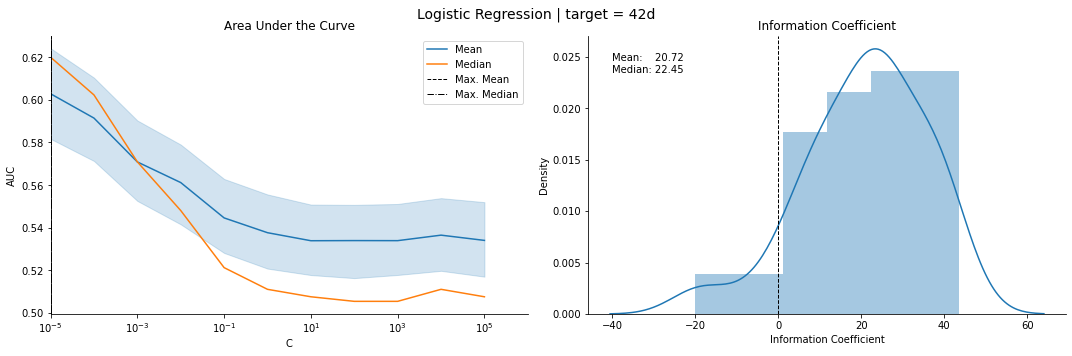

In [19]:
# Plotting AUC vs C and IC Histogram
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores_list[mic], estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores_list[mic].groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores_list[mic][log_scores_list[mic].C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression | target = 42d', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [94]:
# Converting to binary classes
y = (y>0).astype(int)
y_train = (y_train>0).astype(int)

In [95]:
# Fitting model to training set and predicting movements
y_pred = pd.DataFrame(index = y.index)
for x in range(len(targets)):
    c = log_scores_list[x].groupby('C').auc.max().idxmax()
    model = LogisticRegression(C=c,fit_intercept=True,n_jobs=-1)
    pipe = Pipeline([('scaler', StandardScaler()),('model', model)])
    pipe.fit(X=X_train, y=y_train.iloc[:,x])
    y_p = pipe.predict(X)
    y_p = pd.DataFrame(y_p, index=y.index, columns=[y.columns[x]])
    y_pred = y_pred.join(y_p)

In [99]:
# Converting predictions to DataFrame
y_pred = pd.DataFrame(y_pred, index=y.index, columns=y.columns)
y_pred

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02           0           1            1            1   
       2015-01-05           0           1            1            1   
       2015-01-06           0           1            1            1   
       2015-01-07           0           1            1            1   
       2015-01-08           0           1            1            1   
...                       ...         ...          ...          ...   
ZTS    2020-09-25           0           0            0            0   
       2020-09-28           0           0            0            0   
       2020-09-29           0           0            0            0   
       2020-09-30           0           0            0            0   
       2020-10-01           0           0            0            0   

                   target42day  target63day  
ticker date                                  
A      2015-01-02            1            1  
       2015-01-05            1            1  
       2015-01-06            1            1  
       2015-01-07            1            1  
       2015-01-08            1            1  
...                        ...          ...  
ZTS    2020-09-25            0            0  
       2020-09-28            0            0  
       2020-09-29            0            0  
       2020-09-30            0            0  
       2020-10-01            0            0  

[695339 rows x 6 columns]

In [100]:
#Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.date = pd.to_datetime(ohlcv.date)
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [101]:
# Joining OHLCV data with predictions
log_preds = ohlcv.join(y_pred).dropna()
log_preds.to_csv('./predictions/log_preds.csv')